# RNN with LSTM for japanese character classification

In [1]:
from google.colab import drive, files
import os
drive.mount("/content/gdrive")
%cd gdrive/My Drive/Colab\ Notebooks/
if not os.path.exists('japanese-character-classification'):
    !git clone https://github.com/erikhelmut/japanese-character-classification.git
    %cd japanese-character-classification
else:
    %cd japanese-character-classification/
    !git pull
#%pip install -r requirements.txt
#%cd notebooks/

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks
Cloning into 'japanese-character-classification'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 495 (delta 57), reused 74 (delta 28), pack-reused 388
Receiving objects: 100% (495/495), 3.66 MiB | 13.68 MiB/s, done.
Resolving deltas: 100% (176/176), done.
Checking out files: 100% (159/159), done.
/content/gdrive/My Drive/Colab Notebooks/japanese-character-classification


In [11]:
import time
import math
import random

import sys
import inspect
import os
import glob
import csv

import torch
import torch.nn as nn

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from src.data.build_features import load_data, file_to_tensor, character_to_tensor, random_training_example

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Define network structure

In [12]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, n_layers, n_characters):
        super(RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        self.rnn = nn.RNN(input_size, hidden_size, n_layers, batch_first=False)
        # -> x of shape (seq_len, batch, hidden_size)
        self.fc = nn.Linear(hidden_size, n_characters)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        # initial hidden- & cell-state
        h0 = torch.zeros(self.n_layers, x.size(1), self.hidden_size).to(device)
        
        # output of shape (seq_len, batch, n_directions * hidden_size)
        out, _ = self.rnn(x, h0)
        
        # only last Time-Step
        out = out[-1, :, :]
        
        out = self.fc(out)
        out = self.softmax(out)

        return out

## Define helper functions for neural network's training

In [13]:
def train(file_tensor, character_tensor):
    output = model(file_tensor)
    loss = criterion(output, character_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

def character_from_output(output):
    character_idx = torch.argmax(output).item()
    return all_characters[character_idx]

## Defining hyperparameters of neural network's training

In [23]:
# load train dataset
character_files, all_characters = load_data(path="../data/train/")

# hyper parameters
input_size = 3 # features: x_acc, y_acc, z_acc
n_characters = len(all_characters) # output_size
hidden_size = 128
n_layers = 1

learning_rate = 0.001

## Start training loop

In [29]:
# initialize neural network   
model = RNN(input_size, hidden_size, n_layers, n_characters).to(device)

# loss and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

current_loss = 0
all_losses = []

print_every = 4000#5000
plot_every = 400#1000
n_iters = 40000

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for i in range(1, n_iters + 1):
    character, file, character_tensor, file_tensor = random_training_example(character_files, all_characters)
    output, loss = train(file_tensor.to(device), character_tensor.to(device))
    current_loss += loss
    
    # print iter number, loss, name and guess
    if i % print_every == 0:
        guess = character_from_output(output)
        correct = '✓' if guess == character else '✗ (%s)' % character
        print('%d %d%% (%s) %.4f %s / %s %s' % (i, i / n_iters * 100, timeSince(start), loss, file, guess, correct))

    # add current loss avg to list of losses
    if i % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

4000 10% (0m 43s) 0.0645 ../data/test/e__82254.csv / e ✓
8000 20% (1m 27s) 0.8979 ../data/test/u__88458.csv / o ✗ (u)
12000 30% (2m 10s) 0.1799 ../data/test/i__75461.csv / i ✓
16000 40% (2m 54s) 0.0223 ../data/test/e__76682.csv / e ✓
20000 50% (3m 37s) 0.1397 ../data/test/o__76748.csv / o ✓
24000 60% (4m 21s) 0.0131 ../data/test/e__76682.csv / e ✓
28000 70% (5m 4s) 0.0120 ../data/test/a__96486.csv / a ✓
32000 80% (5m 47s) 0.0072 ../data/test/u__88458.csv / u ✓
36000 90% (6m 31s) 0.0012 ../data/test/i__89095.csv / i ✓
40000 100% (7m 14s) 0.0036 ../data/test/a__96486.csv / a ✓


## Plot LOSS-function

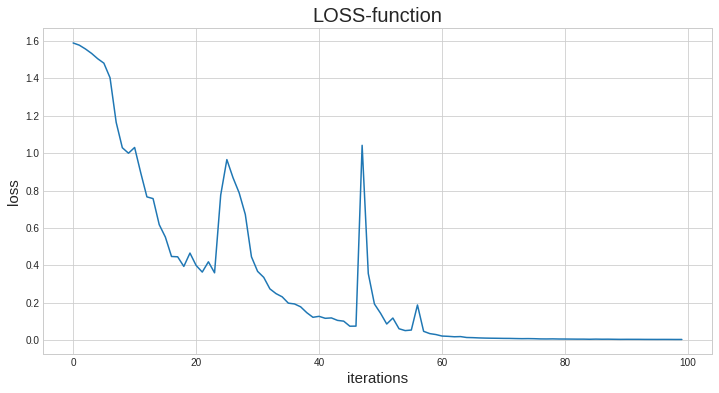

In [30]:
# create figure
mpl.style.use("seaborn-whitegrid")
plt.figure(figsize=(12,6))
# create plot
plt.plot(all_losses)
# title and labels
plt.title("LOSS-function", fontsize=20)
plt.xlabel("iterations", fontsize=15)
plt.ylabel("loss", fontsize=15)
# show plot
plt.show()

## Save model

In [31]:
%cd ../models/
FILE = "2.0-recurrent-neural-network-model.pth"
torch.save(model.state_dict(), FILE)
%cd ../notebooks/

/content/gdrive/My Drive/Colab Notebooks/japanese-character-classification/models
/content/gdrive/My Drive/Colab Notebooks/japanese-character-classification/notebooks


## Load model

In [32]:
%cd ../models/
FILE = "2.0-recurrent-neural-network-model.pth"
loaded_model = RNN(input_size, hidden_size, n_layers, n_characters).to(device)
loaded_model.load_state_dict(torch.load(FILE, map_location=device))
loaded_model.eval()
%cd ../notebooks/

/content/gdrive/My Drive/Colab Notebooks/japanese-character-classification/models
/content/gdrive/My Drive/Colab Notebooks/japanese-character-classification/notebooks


## Determine accuracy

characters in test data:  ['a', 'e', 'i', 'o', 'u']
../data/test/a__88470.csv / a ✓
../data/test/a__94789.csv / a ✓
../data/test/a__96486.csv / a ✓
../data/test/a__97545.csv / a ✓
../data/test/a__98539.csv / a ✓
../data/test/e__70433.csv / e ✓
../data/test/e__76682.csv / e ✓
../data/test/e__82254.csv / e ✓
../data/test/e__83191.csv / e ✓
../data/test/e__84585.csv / e ✓
../data/test/i__75461.csv / i ✓
../data/test/i__81833.csv / i ✓
../data/test/i__88644.csv / i ✓
../data/test/i__89095.csv / i ✓
../data/test/i__91889.csv / i ✓
../data/test/o__54903.csv / o ✓
../data/test/o__63253.csv / o ✓
../data/test/o__67824.csv / o ✓
../data/test/o__72419.csv / o ✓
../data/test/o__76748.csv / o ✓
../data/test/u__81848.csv / u ✓
../data/test/u__82120.csv / u ✓
../data/test/u__83897.csv / u ✓
../data/test/u__85976.csv / u ✓
../data/test/u__88458.csv / u ✓
../data/test/u__93521.csv / u ✓

accuracy = 100.00 %



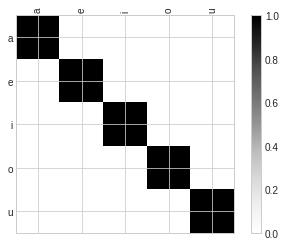

In [33]:
# load test dataset
character_files, all_characters = load_data(path="../data/test/")
print("characters in test data: ", all_characters)

# keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_characters, n_characters)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    
    for character in all_characters:
        # all files from one character
        for file in character_files[character]:
            file_tensor = file_to_tensor(file).to(device)
            # get output
            output = loaded_model(file_tensor).to(device)
            # get character from output
            guess = character_from_output(output)
            n_samples += 1
            if guess == character:
                n_correct += 1
                correct = "✓"
            else:
                correct = "✗ (%s)" % character
            confusion[all_characters.index(character)][all_characters.index(guess)] += 1
            
            print(file, "/", guess, correct)

# normalize by dividing every row by its sum
for i in range(n_characters):
    confusion[i] = confusion[i] / confusion[i].sum()

acc = 100.0 * n_correct / n_samples
print(f"\naccuracy = {acc:.2f} %\n")

# set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# set up axes
ax.set_xticklabels([''] + all_characters, rotation=90)
ax.set_yticklabels([''] + all_characters)

# force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()